### PREPROCESSING AND ALGORITHM IMPLEMENTATION FOR FIT PREDICTION
#### NAME: Priyanka Raju
#### SJSU ID: 013839865

**Mount drive to acccess files for the project**

In [0]:
! pip install matplotlib==3.1.0

In [0]:
from google.colab import drive
drive.mount('/content/drive')

**Install category_encoders to convert the categorical features to numeric features using different techniques**
http://contrib.scikit-learn.org/categorical-encoding/index.html

In [5]:
! pip install category_encoders

     |████████████████████████████████| 102kB 1.7MB/s 


**Install PyLMNN for Large Margin Nearest Neighbor implementation along with K-NN**

https://pypi.org/project/PyLMNN/

In [2]:
! pip3 install pylmnn

  Created wheel for pylmnn: filename=PyLMNN-1.6.3-cp36-none-any.whl size=21049 sha256=4f15ad6bb5208e4bfdf1806cefcc967395517d351db9c5bd1b8be1e66ba89be4
  Stored in directory: /root/.cache/pip/wheels/62/a0/bd/b84f85bb04c14eac1c1c4e52c7b49fc7f4c2ed6ffe6ad6f2a7
Successfully built pylmnn


https://scikit-learn.org/

In [6]:
import numpy as np
import pandas as pd

# CATEGORICAL TO NUMERICAL ENCODING
import category_encoders as ce

# TO PLOT 
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

# Model selection for splitting data into train and test 
from sklearn.model_selection import train_test_split
# Import GridsearchCV to 
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from pylmnn import LargeMarginNearestNeighbor as LMNN

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import cross_val_score
import warnings

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Reading from the merged dataset

In [0]:
df = pd.read_json('/content/drive/My Drive/Colab Notebooks/256-project/updatedFitDF.json', lines=True)

In [0]:
df.head()

,bra size,category,cup size,fit,height,hips,item_id,length,quality,shoe size,shoe width,size,user_id,age,body type,bust size,rented for,weight,fit_to_numeric
0,34,new,d,small,167.6,38.000000,123373,just right,5.0,0.0,Unspecified,7,991571,33,Unspecified,Unspecified,Unspecified,137.391709,1
1,36,new,b,small,157.5,30.000000,123373,just right,3.0,0.0,Unspecified,13,587883,33,Unspecified,Unspecified,Unspecified,137.391709,1
2,32,new,b,small,170.2,40.358501,123373,slightly long,2.0,9.0,Unspecified,7,395665,33,Unspecified,Unspecified,Unspecified,137.391709,1
3,36,new,dd/e,fit,165.1,40.358501,123373,just right,5.0,0.0,Unspecified,21,875643,33,Unspecified,Unspecified,Unspecified,137.391709,2
4,36,new,b,small,157.5,40.358501,123373,slightly long,5.0,0.0,Unspecified,18,944840,33,Unspecified,Unspecified,Unspecified,137.391709,1


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275334 entries, 0 to 275333
Data columns (total 19 columns):
bra size          275334 non-null int64
category          275334 non-null object
cup size          275334 non-null object
fit               275334 non-null object
height            275334 non-null float64
hips              275334 non-null float64
item_id           275334 non-null int64
length            275334 non-null object
quality           275334 non-null float64
shoe size         275334 non-null float64
shoe width        275334 non-null object
size              275334 non-null int64
user_id           275334 non-null int64
age               275334 non-null int64
body type         275334 non-null object
bust size         275334 non-null object
rented for        275334 non-null object
weight            275334 non-null float64
fit_to_numeric    275334 non-null int64
dtypes: float64(5), int64(6), object(8)
memory usage: 39.9+ MB


### Split the data such that make the Fit as target variable

In [0]:
X = df.drop(columns={'fit','fit_to_numeric'}, axis = 1)
y = df['fit_to_numeric']

In [0]:
df.shape

(275334, 19)

In [0]:
X.shape

(275334, 17)

In [0]:
y.shape

(275334,)

### Splitting data into train and test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Preprocessing in terms of converting categorical attributes to numerical
https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

### 1. 'length' attribute can be viewd as ordinal attribute type, we can use the Ordinal Encoder to assign numeric values to this column

In [0]:
X_train['length'].sort_values(ascending=True).unique()

array(['Unspecified', 'just right', 'slightly long', 'slightly short',
       'very long', 'very short'], dtype=object)

In [0]:
mappingLen=[{'col': 'length','mapping': {'Unspecified': 0, 'very short': 1, 'slightly short': 2,'just right':3,'slightly long':4,'very long':5}}]

ceOrdLen = ce.OrdinalEncoder(cols=['length'],return_df=True,mapping=mappingLen)
X_train = ceOrdLen.fit_transform(X_train,y_train)

In [0]:
X_train.shape

(220267, 17)

In [0]:
X_test = ceOrdLen.transform(X_test)

In [0]:
X_test.shape

(55067, 17)

In [0]:
X_train['length'].sort_values(ascending=True).unique()

array([0, 1, 2, 3, 4, 5])

###  2. 'shoe width' attribute can be viewd as ordinal attribute type, we can use the Ordinal Encoder to assign numeric values to this column

In [0]:
X_train['shoe width'].sort_values(ascending=True).unique()

array(['Unspecified', 'average', 'narrow', 'wide'], dtype=object)

In [0]:
mappingShoe=[{'col': 'shoe width','mapping': {'Unspecified': 0, 'average': 1, 'narrow': 2,'wide':3}}]

ceOrdShoe = ce.OrdinalEncoder(cols=['shoe width'],return_df=True,mapping=mappingShoe)
X_train = ceOrdShoe.fit_transform(X_train,y_train)

In [0]:
X_train['shoe width'].sort_values(ascending=True).unique()

array([0, 1, 2, 3])

In [0]:
X_test = ceOrdShoe.transform(X_test)

In [0]:
X_test.shape

(55067, 17)

### 3. 'body type' attribute can be converted from categorical to numerical using Leave One Out Encoding technique

In [0]:
X_train['body type'].sort_values(ascending=True).unique()

array(['Unspecified', 'apple', 'athletic', 'full bust', 'hourglass',
       'pear', 'petite', 'straight & narrow'], dtype=object)

In [0]:
ceLOOBT = ce.LeaveOneOutEncoder(cols=['body type'],return_df=True)
X_train = ceLOOBT.fit_transform(X_train,y_train)

In [0]:
X_train['body type'].sort_values(ascending=True).unique()

array([1.98214184, 1.98217041, 1.98219898, 1.98393574, 1.98418675,
       1.98443775, 1.98620806, 1.98629215, 1.98637625, 1.99631167,
       1.99632452, 1.99633737, 1.99662208, 1.99664475, 1.99666742,
       1.99808221, 1.9981656 , 1.99824898, 2.00334183, 2.00339847,
       2.00345511, 2.01869211, 2.01874825, 2.01880438])

In [0]:
X_test = ceLOOBT.transform(X_test)

In [0]:
X_test.shape

(55067, 17)

### 4. 'rented for' attribute can be converted from categorical to numerical using Binay Encoding technique

In [0]:
X_train['rented for'].sort_values(ascending=True).unique()

array(['Unspecified', 'date', 'everyday', 'formal affair', 'other',
       'party', 'party: cocktail', 'vacation', 'wedding', 'work'],
      dtype=object)

In [0]:
ceBinRF = ce.BinaryEncoder(cols=['rented for'],return_df=True,drop_invariant=False)
X_train = ceBinRF.fit_transform(X_train,y_train)

In [0]:
X_train.head()

,bra size,category,cup size,height,hips,item_id,length,quality,shoe size,shoe width,size,user_id,age,body type,bust size,rented for_0,rented for_1,rented for_2,rented for_3,rented for_4,weight
88803,36,shirt,Unspecified,162.6,40.358501,280734,0,5.0,0.0,0,8,450977,40,1.996645,34d,0,0,0,0,1,128.000000
40438,38,top,h,170.2,49.000000,429442,3,4.0,10.5,1,26,111847,33,1.996325,Unspecified,0,0,0,1,0,137.391709
159438,36,dress,Unspecified,167.6,40.358501,172027,0,5.0,0.0,0,1,652969,33,1.982142,34b,0,0,0,1,1,135.000000
56649,40,top,d,167.6,52.000000,645085,3,3.0,0.0,0,26,867290,33,1.996312,Unspecified,0,0,0,1,0,137.391709
93003,36,dress,Unspecified,172.7,40.358501,299987,0,2.0,0.0,0,8,620961,27,1.982142,32c,0,0,1,0,0,130.000000


In [0]:
X_test = ceBinRF.transform(X_test)

In [0]:
X_test.head()

,bra size,category,cup size,height,hips,item_id,length,quality,shoe size,shoe width,size,user_id,age,body type,bust size,rented for_0,rented for_1,rented for_2,rented for_3,rented for_4,weight
53717,38,top,b,167.6,40.358501,621405,4,4.0,0.0,0,20,729138,33,1.996325,Unspecified,0,0,0,1,0,137.391709
79620,44,outerwear,ddd/f,175.3,40.358501,785517,3,5.0,0.0,0,26,434935,33,1.996325,Unspecified,0,0,0,1,0,137.391709
82326,36,outerwear,Unspecified,175.3,40.358501,806856,3,4.0,9.5,0,20,944453,33,1.996325,Unspecified,0,0,0,1,0,137.391709
189450,36,sheath,Unspecified,170.2,40.358501,1731993,0,5.0,0.0,0,16,524441,28,1.996325,34d,0,0,1,0,0,145.000000
114245,36,dress,Unspecified,170.2,40.358501,1428822,0,5.0,0.0,0,12,896669,42,1.982171,36b,0,0,1,0,1,140.000000


### 5. 'category' attribute has around 60 classes. To convert to numeric encoder there will 60 new features created. Instead we can try using Leave one out encoding technique. In this encoding technique the value for caterory is calculated based on the 

In [0]:
X['category'].sort_values(ascending=True).unique()

array(['ballgown', 'blazer', 'blouse', 'bomber', 'bottoms', 'buttondown',
       'cami', 'cape', 'cardigan', 'coat', 'combo', 'crewneck', 'culotte',
       'dress', 'duster', 'frock', 'gown', 'henley', 'hoodie', 'jacket',
       'jeans', 'jogger', 'jumpsuit', 'kaftan', 'kimono', 'knit',
       'leggings', 'maxi', 'midi', 'mini', 'new', 'outerwear', 'overalls',
       'overcoat', 'pant', 'parka', 'peacoat', 'poncho', 'print',
       'pullover', 'romper', 'sale', 'sheath', 'shirt', 'shirtdress',
       'skirt', 'suit', 'sweater', 'sweatpants', 'sweatshirt', 't-shirt',
       'tank', 'tight', 'top', 'trench', 'trouser', 'tunic', 'turtleneck',
       'vest', 'wedding'], dtype=object)

In [0]:
ceLOOCat = ce.LeaveOneOutEncoder(cols=['category'],return_df=True)
X_train = ceLOOCat.fit_transform(X_train,y_train)

In [0]:
X_train['category'].sort_values(ascending=True).unique()

array([1.54545455, 1.63636364, 1.70056497, 1.70621469, 1.71186441,
       1.78688525, 1.8       , 1.80327869, 1.81967213, 1.875     ,
       1.88156028, 1.8822695 , 1.88297872, 1.92033557, 1.9204006 ,
       1.92046563, 1.9223301 , 1.92307692, 1.92857143, 1.93203883,
       1.94174757, 1.94440218, 1.9444607 , 1.94451923, 1.95098039,
       1.95238095, 1.95348837, 1.96078431, 1.96465863, 1.96511628,
       1.96546185, 1.96626506, 1.97058824, 1.97234531, 1.97242738,
       1.97250944, 1.97619048, 1.97674419, 1.97745491, 1.97795591,
       1.97845691, 1.99026105, 1.99027224, 1.99028344, 1.99202321,
       1.99226493, 1.99250665, 1.9956384 , 1.99566619, 1.99569397,
       1.99585957, 2.        , 2.00212993, 2.00266241, 2.00319489,
       2.01401869, 2.01869159, 2.01948052, 2.02336449, 2.02364641,
       2.0238674 , 2.0240884 , 2.02597403, 2.03246753, 2.04491726,
       2.04521277, 2.04550827, 2.05434335, 2.05475504, 2.05516674,
       2.05564648, 2.05728314, 2.0589198 , 2.06563707, 2.06756

In [0]:
X_test = ceLOOCat.transform(X_test)

In [0]:
X_test.shape

(55067, 21)

### 6. 'bust size' categorical feature can be converted to numerical feature based on Ordinal Encoding

In [0]:
X_train['bust size'].sort_values(ascending=True).unique()

array(['28a', '28aa', '28b', '28c', '28d', '28dd', '28ddd/e', '28f',
       '28g', '28h', '30a', '30aa', '30b', '30c', '30d', '30dd',
       '30ddd/e', '30f', '30g', '30h', '30i', '32a', '32aa', '32b', '32c',
       '32d', '32d+', '32dd', '32ddd/e', '32f', '32g', '32h', '32i',
       '32j', '34a', '34aa', '34b', '34c', '34d', '34d+', '34dd',
       '34ddd/e', '34f', '34g', '34h', '34i', '34j', '36a', '36aa', '36b',
       '36c', '36d', '36d+', '36dd', '36ddd/e', '36f', '36g', '36h',
       '36i', '36j', '38a', '38aa', '38b', '38c', '38d', '38d+', '38dd',
       '38ddd/e', '38f', '38g', '38h', '38i', '38j', '40b', '40c', '40d',
       '40dd', '40ddd/e', '40f', '40g', '40h', '40i', '40j', '42b', '42c',
       '42d', '42dd', '42ddd/e', '42f', '42g', '42h', '44b', '44c', '44d',
       '44dd', '44ddd/e', '44f', '44g', '46c', '46ddd/e', '46f', '48d',
       '48dd', 'Unspecified'], dtype=object)

In [0]:
ceOrdBuSize = ce.OrdinalEncoder(cols=['bust size'],return_df=True)
X_train = ceOrdBuSize.fit_transform(X_train,y_train)

In [0]:
X_train['bust size'].sort_values(ascending=True).unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104])

In [0]:
X_test = ceOrdBuSize.transform(X_test)

### 7. 'cup size' categorical feature can be converted to numerical feature based on Ordinal Encoding

In [0]:
X_train['cup size'].sort_values(ascending=True).unique()

array(['Unspecified', 'a', 'aa', 'b', 'c', 'd', 'dd/e', 'ddd/f', 'dddd/g',
       'h', 'i', 'j', 'k'], dtype=object)

In [0]:
ceOrdCupSize = ce.OrdinalEncoder(cols=['cup size'],return_df=True)
X_train = ceOrdCupSize.fit_transform(X_train,y_train)

In [0]:
X_train['cup size'].sort_values(ascending=True).unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [0]:
X_test = ceOrdCupSize.transform(X_test)

In [0]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220267 entries, 88803 to 128037
Data columns (total 21 columns):
bra size        220267 non-null int64
category        220267 non-null float64
cup size        220267 non-null int64
height          220267 non-null float64
hips            220267 non-null float64
item_id         220267 non-null int64
length          220267 non-null int64
quality         220267 non-null float64
shoe size       220267 non-null float64
shoe width      220267 non-null int64
size            220267 non-null int64
user_id         220267 non-null int64
age             220267 non-null int64
body type       220267 non-null float64
bust size       220267 non-null int64
rented for_0    220267 non-null int64
rented for_1    220267 non-null int64
rented for_2    220267 non-null int64
rented for_3    220267 non-null int64
rented for_4    220267 non-null int64
weight          220267 non-null float64
dtypes: float64(7), int64(14)
memory usage: 37.0 MB


In [0]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55067 entries, 53717 to 104954
Data columns (total 21 columns):
bra size        55067 non-null int64
category        55067 non-null float64
cup size        55067 non-null int64
height          55067 non-null float64
hips            55067 non-null float64
item_id         55067 non-null int64
length          55067 non-null int64
quality         55067 non-null float64
shoe size       55067 non-null float64
shoe width      55067 non-null int64
size            55067 non-null int64
user_id         55067 non-null int64
age             55067 non-null int64
body type       55067 non-null float64
bust size       55067 non-null float64
rented for_0    55067 non-null int64
rented for_1    55067 non-null int64
rented for_2    55067 non-null int64
rented for_3    55067 non-null int64
rented for_4    55067 non-null int64
weight          55067 non-null float64
dtypes: float64(8), int64(13)
memory usage: 9.2 MB


In [0]:
cols = X_train.columns
cols = ['bra size', 'category', 'cup size', 'height', 'hips', 'item_id',
       'length', 'quality', 'shoe size', 'shoe width', 'size', 'user_id',
       'age', 'body type', 'bust size', 'rented for_0', 'rented for_1',
       'rented for_2', 'rented for_3', 'rented for_4', 'weight']

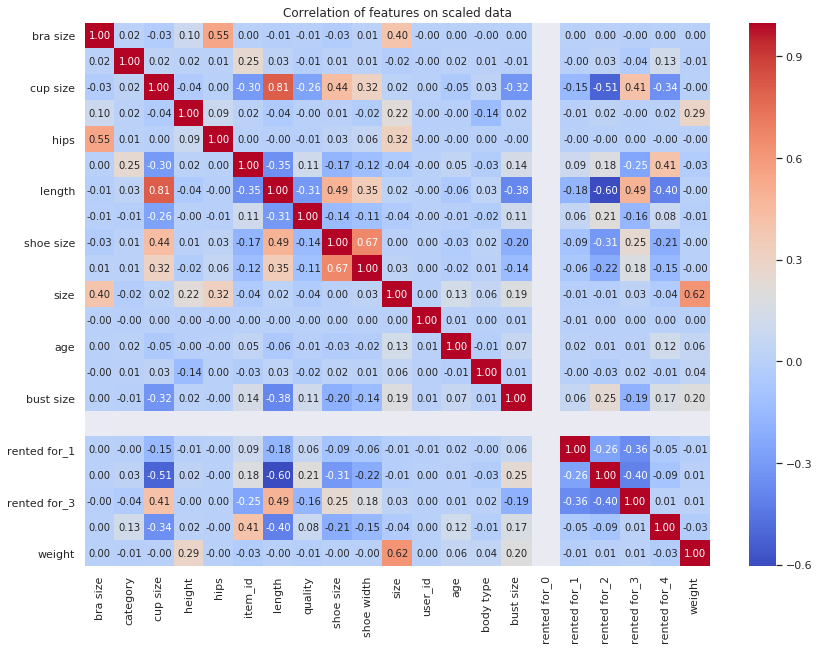

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
new = scaler.transform(X_train)
new  = pd.DataFrame(new,columns=cols)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
corr = new.corr()
g = sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
g.figure.set_size_inches(14,10)
plt.title('Correlation of features on scaled data')    
plt.show()

**Based on the correlation map and analysis on dataset the features are selected for building the model**

In [0]:
X_train = X_train[['category','height','item_id','weight','size','user_id','length','hips']]
X_test = X_test[['category','height','item_id','weight','size','user_id','length','hips']]

In [0]:
X_train.shape

(220267, 8)

In [0]:
X_test.shape

(55067, 8)

**K Nearest Neigbor Algorithm Implementation**

**1. Training with the default Knn model** 

In [0]:
knnDefault = KNeighborsClassifier()
knnDefault.fit(X_train, y_train)
print("Accuracy for default k-NN model with k=5: " ,round(((knnDefault.score(X_test,y_test))*100),2),"%")

Accuracy for default k-NN model with k=5:  67.03 %


[[  718  6758   185]
 [ 2897 35847  1076]
 [  542  6696   348]]


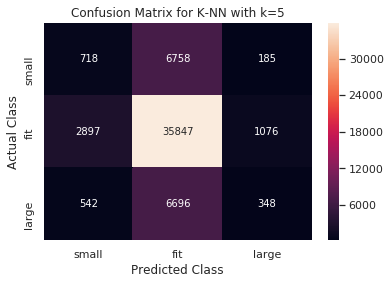

In [0]:
print(confusion_matrix(y_test, knnDefault.predict(X_test)))
plt.title('Confusion Matrix for K-NN with k=5')
sns.heatmap(confusion_matrix(y_test, knnDefault.predict(X_test)),annot=True,fmt='d',xticklabels={'small':0,'fit':1,'large':2},yticklabels={'small':0,'fit':1,'large':2})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [0]:
print('Classification Report')
target_names = ['small', 'fit', 'large']
print(classification_report(y_test, knnDefault.predict(X_test), target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       small       0.17      0.09      0.12      7661
         fit       0.73      0.90      0.80     39820
       large       0.22      0.05      0.08      7586

    accuracy                           0.67     55067
   macro avg       0.37      0.35      0.33     55067
weighted avg       0.58      0.67      0.61     55067



**2. Training with best parameters obtained with GridSearchCV**

In [0]:
param_gridKnn = {
    'n_neighbors': [5,10,20],
    'weights': ['uniform','distance']
}

In [0]:
knn_gs = GridSearchCV(KNeighborsClassifier(), param_gridKnn, cv=3)
knn_gs.fit(X_train,y_train)
knn_gs.best_params_

{'n_neighbors': 20, 'weights': 'uniform'}

In [0]:
knnModel = KNeighborsClassifier(n_neighbors=20,weights='uniform')
knnModel.fit(X_train, y_train)
print("Accuracy for k-NN model with k=20: " ,round(((knnModel.score(X_test,y_test))*100),2),"%")

Accuracy for default k-NN model with k=20:  72.09 %


[[   34  7608    19]
 [  100 39650    70]
 [   16  7557    13]]


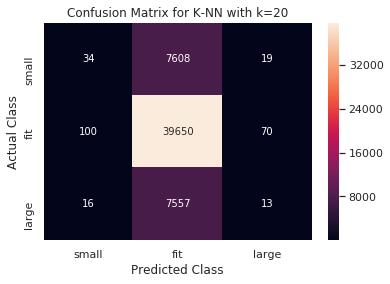

In [0]:
print(confusion_matrix(y_test, knnModel.predict(X_test)))
plt.title('Confusion Matrix for K-NN with k=20')
sns.heatmap(confusion_matrix(y_test, knnModel.predict(X_test)),annot=True,fmt='d',xticklabels={'small':0,'fit':1,'large':2},yticklabels={'small':0,'fit':1,'large':2})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [0]:
print('Classification Report')
target_names = ['small', 'fit', 'large']
print(classification_report(y_test, knnModel.predict(X_test), target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       small       0.23      0.00      0.01      7661
         fit       0.72      1.00      0.84     39820
       large       0.13      0.00      0.00      7586

    accuracy                           0.72     55067
   macro avg       0.36      0.33      0.28     55067
weighted avg       0.57      0.72      0.61     55067



**3. Large Margin Nearest Neighbor**

**1. With default parameters k=3**

In [0]:
lmnn = LMNN()
lmnn.fit(X_train,y_train)

LargeMarginNearestNeighbor(callback=None, impostor_store='auto', init='pca',
                           max_impostors=500000, max_iter=50, n_components=None,
                           n_jobs=1, n_neighbors=3, neighbors_params=None,
                           random_state=None, store_opt_result=False, tol=1e-05,
                           verbose=0, warm_start=False, weight_push_loss=0.5)

To compare the performance between K-NN and applying the LMNN transformation for k=3

In [0]:
knnWithML = KNeighborsClassifier(n_neighbors=3)
knnWithML.fit(X_train,y_train)
print("Accuracy for default k-NN model with k=3: " ,round(((knnWithML.score(X_test,y_test))*100),2),"%")
print(confusion_matrix(y_test, knnWithML.predict(X_test)))

plt.title('Confusion Matrix for k-NN with k=3')
sns.heatmap(confusion_matrix(y_test, knnWithML3.predict(lmnn.transform(X_test))),annot=True,fmt='d',xticklabels={'small':0,'fit':1,'large':2},yticklabels={'small':0,'fit':1,'large':2})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

Accuracy for default k-NN model with k=3:  62.28 %
[[ 1220  6068   373]
 [ 5191 32423  2206]
 [  951  5981   654]]


In [0]:
knnWithML3 = KNeighborsClassifier(n_neighbors=3)
knnWithML3.fit(lmnn.transform(X_train), y_train)
print("Accuracy for LMNN model with k=3: " ,round(((knnWithML3.score(lmnn.transform(X_test),y_test))*100),4),"%")

Accuracy for LMNN model with k=3:  62.4821 %


[[ 1293  6020   348]
 [ 5198 32507  2115]
 [ 1036  5943   607]]


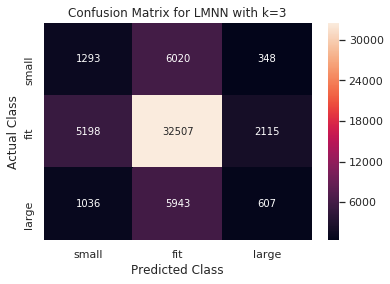

In [0]:
print(confusion_matrix(y_test, knnWithML3.predict(lmnn.transform(X_test))))
plt.title('Confusion Matrix for LMNN with k=3')
sns.heatmap(confusion_matrix(y_test, knnWithML3.predict(lmnn.transform(X_test))),annot=True,fmt='d',xticklabels={'small':0,'fit':1,'large':2},yticklabels={'small':0,'fit':1,'large':2})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [0]:
print('Classification Report')
target_names = ['small', 'fit', 'large']
print(classification_report(y_test, knnWithML3.predict(lmnn.transform(X_test)), target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       small       0.17      0.17      0.17      7661
         fit       0.73      0.82      0.77     39820
       large       0.20      0.08      0.11      7586

    accuracy                           0.62     55067
   macro avg       0.37      0.36      0.35     55067
weighted avg       0.58      0.62      0.60     55067



**2. with parameter tuning of k=50**

In [0]:
lmnn50 = LMNN(n_neighbors=50, max_iter=50)
lmnn50.fit(X_train, y_train)

LargeMarginNearestNeighbor(callback=None, impostor_store='auto', init='pca',
                           max_impostors=500000, max_iter=50, n_components=None,
                           n_jobs=1, n_neighbors=50, neighbors_params=None,
                           random_state=None, store_opt_result=False, tol=1e-05,
                           verbose=0, warm_start=False, weight_push_loss=0.5)

In [0]:
knnWithML50 = KNeighborsClassifier(n_neighbors=50)
knnWithML50.fit(lmnn50.transform(X_train), y_train)
print("Accuracy for LMNN model with k=50: " ,round(((knnWithML50.score(lmnn50.transform(X_test),y_test))*100),4),"%")

Accuracy for LMNN model with k=50:  72.3101 %


[[    0  7661     0]
 [    0 39818     2]
 [    0  7585     1]]


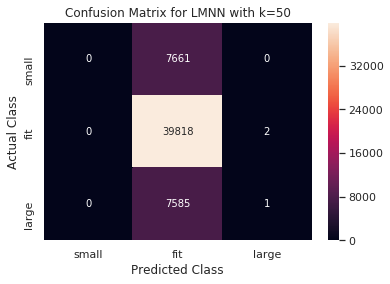

In [0]:
print(confusion_matrix(y_test, knnWithML50.predict(lmnn50.transform(X_test))))
plt.title('Confusion Matrix for LMNN with k=50')
sns.heatmap(confusion_matrix(y_test, knnWithML50.predict(lmnn50.transform(X_test))),annot=True,fmt='d',xticklabels={'small':0,'fit':1,'large':2},yticklabels={'small':0,'fit':1,'large':2})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [0]:
print('Classification Report')
target_names = ['small', 'fit', 'large']
print(classification_report(y_test, knnWithML50.predict(lmnn50.transform(X_test)), target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       small       0.00      0.00      0.00      7661
         fit       0.72      1.00      0.84     39820
       large       0.33      0.00      0.00      7586

    accuracy                           0.72     55067
   macro avg       0.35      0.33      0.28     55067
weighted avg       0.57      0.72      0.61     55067



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**EVALUATION OF RESULTS**

In [0]:
accKnn5 = 67.03
accLmnn3 = 62.48
accKnn20 = 72.09
accLmnn50 = 72.31
classification = pd.DataFrame({"classifier": ['K-NN(k=5)','K-NN(k=20)','LMNN(k=3)', 'LMNN(k=50)'],
                           "acc": [accKnn5,accKnn20,accLmnn3,accLmnn50]},
                            columns = ['classifier','acc'])
classification = classification.sort_values(by='acc', ascending = False)

Text(0.5, 1.0, 'Performance of the Nearest Neighbor Classifier')

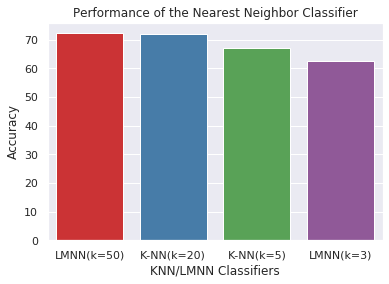

In [0]:
# sns.barplot(classification['acc'],classification['classifier'], palette = 'Set1')
sns.barplot(classification['classifier'],classification['acc'], palette='Set1')
plt.ylabel('Accuracy')
plt.xlabel("KNN/LMNN Classifiers")
plt.title('Performance of the Nearest Neighbor Classifier')

**CLASSIFICATION MODEL COMPARISON WITH RESPECT TO EVALUATION METRICS ACCURACY**

In [0]:
accLR = 72.31
accNB = 72.29
accLMNN = 72.31

comparision = pd.DataFrame({"classifier": ['Logistic Regression','Naive Bayes','Large Margin NN'],
                           "acc": [accLR,accNB,accLMNN]},
                            columns = ['classifier','acc'])
comparision = comparision.sort_values(by='acc', ascending = False)

Text(0.5, 1.0, 'Performance comparison of the Classifier')

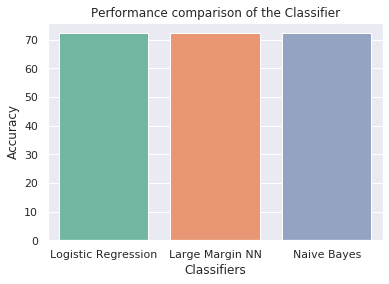

In [8]:
# sns.barplot(classification['acc'],classification['classifier'], palette = 'Set1')
sns.barplot(comparision['classifier'],comparision['acc'], palette='Set2')
plt.ylabel('Accuracy')
plt.xlabel("Classifiers")
plt.title('Performance comparison of the Classifier')